# Notebook 01: MRCP Feature Extraction.
Extract movement-related cortical potential (MRCP) features from single-trial EEG data using the bci-core library. This includes computing `area under the curve (AUC)`, `peak amplitud`, and `slope` for each EEG channel per trial.
#### Rational:
- MRCPs are low-frequency deflections preceding movement onset and are useful for intent detection in BCIs.
- Extracting interpretable features (like negative peak or slope) enables early SVM-based classifiers without Deep Learning.
- Motor intent correlates with activity in SMC (sensorimotor cortex) and PFC (prefrontal cortex). MRCPs provide EEG evidence of such intent.
- This forms the baseline for training classifiers in Stage 2, tested locally then deployed via CI/CD pipeline.

### Cell 1. Notebook Header, Imports, and Configuration.
Initialise the notebook with title, dependencies, and reproducibility settings. This prepares the environment for MRCP feature extraction.
#### Rationale:
- Ensures clear scientific naming and proper structure for publication or future CI/CD automation.
- Guarantees version-locking and reproducibility (essential for regulatory and academic contexts).
- Loads the necessary `bci_core` components for preprocessing and feature extraction.

In [1]:
# ============================================================
# Notebook: 01_Extract_MRCP_Features.ipynb
# Purpose: Extract MRCP features (area, peak, slope) from EEG
# Project: Anich Labs BCI Toolkit (bci_core)
# Author: Anich Labs (Estonia) — EU GDPR Compliant
# ============================================================

# -- System & I/O --
import os
import numpy as np
import matplotlib.pyplot as plt

# -- Signal Processing --
from bci_core.preprocessor import SignalPreprocessor
from bci_core.mrcp_feature_extractor import MRCPFeatureExtractor

# -- Reproducibility --
np.random.seed(42)

# -- Display Settings --
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12

# -- Path Setup --
DATA_DIR = '/lab/px/anichlabs/bci-tools/data/'
RAW_PATH = os.path.join(DATA_DIR, 'raw')
PRE_PATH = os.path.join(DATA_DIR, 'clean')
FEAT_PATH = os.path.join(DATA_DIR, 'features')

# -- Create dirs if missing --
for path in [RAW_PATH, PRE_PATH, FEAT_PATH]:
    os.makedirs(path, exist_ok=True)

print('Notebook ready. Dependencies and folders are set.')

'''
`bci_core`is a local editable Python package, not published on PyPI.
It must be installed in editable mode so the Jupyter kernel knows how to
find it during imports. This is essential for proper `import` resolution
in notebooks and tests.
Before importing the package from the project directory `src/bci_core`,
run the next commands in the root (in case of using conda environments):
`conda activate bci`
`pip install -e .`
'''

Notebook ready. Dependencies and folders are set.


'\n`bci_core`is a local editable Python package, not published on PyPI.\nIt must be installed in editable mode so the Jupyter kernel knows how to\nfind it during imports. This is essential for proper `import` resolution\nin notebooks and tests.\nBefore importing the package from the project directory `src/bci_core`,\nrun the next commands in the root (in case of using conda environments):\n`conda activate bci`\n`pip install -e .`\n'

### Cell 2. Load Simulated EEG Trial.
Simulate a 4-channel EEG trial (4 seconds at 250 Hz) with Gaussian noise. This emulates real EEG input to test MRCP feature extraction without hardware.
#### Rationale:
- Allows testing without connecting the BCI board.
- Matches expectect BCI sampling rate and trial length.
- Enables full development and unit testing of MRCP algorithms using synthetic data.

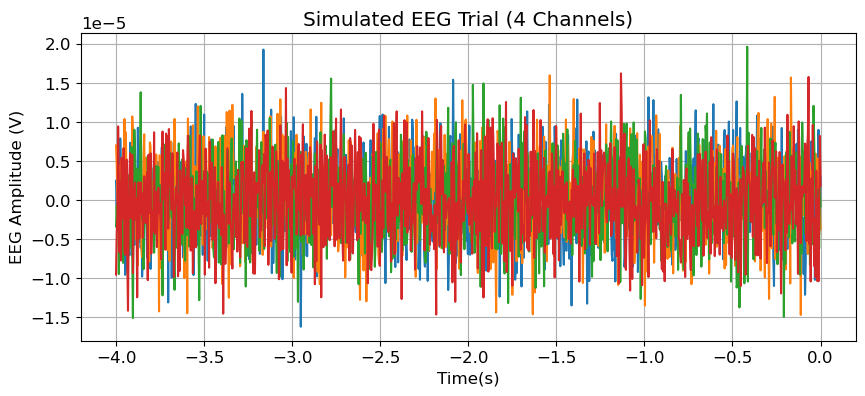

In [2]:
# ===============================================
# Simulate a 4-channel EEG trial (baseline test)
# ===============================================

# -- EEG trial settings --
n_channels = 4
sfreq = 250        # Sampling frequency in Hz.
duration = 4.0     # Trial duration in seconds.
n_samples = int(sfreq * duration)

# -- Generate random EEG signal --
# The amplitude of MRCP (movement preparation) is ~-5 to -20 µV. 
eeg_trial = np.random.randn(n_channels, n_samples) * 5e-6 # Simulated microvolt-level noise.

# -- Time axis: from -4.0 to 0.0 seconds (0.0 = movement onset) --
t = np.linspace(-duration, 0, n_samples)

# -- Plot example --
plt.plot(t, eeg_trial.T)
plt.xlabel('Time(s)')
plt.ylabel('EEG Amplitude (V)')
plt.title('Simulated EEG Trial (4 Channels)')
plt.grid(True)
plt.show()

### Cell 3. Extract MRCP Features (Area, Peak, Slope).
Use the MRCPFeatureExtractor to compute MRCP features for each channel:
- Area under the curve (AUC) from -1.5s to 0.0 s.
- Peak amplitud (most negative deflection).
- Slope of the rising deflection before movement onset.
#### Rationale:
- These features are biologically interpretable markers of movement preparation.
- They can feed a simple classifier like SVM in early BCI prototypes.
- It is possible to validate the full feature extraction pipeline without relying on real EEG yet.

In [3]:
# ============================================
# Extract MRCP features from the EEG trial
# ============================================

# -- Initialise the extractor --
extractor = MRCPFeatureExtractor(sfreq=sfreq)

# -- Compute all MRCP features: area, peak, slope --
features = extractor.extract_all(eeg_trial)

# -- Display --
print('Extracted MRCP Features (per channel):\n')
for ch_idx, ch_feats in features.items():
    print(f'Channel {ch_idx}:')
    for feat_name, feat_value in ch_feats.items():
        print(f'  {feat_name:<6} = {feat_value:.2e}')
    print()

Extracted MRCP Features (per channel):

Channel 0:
  area   = -3.40e-07
  peak   = -1.35e-05
  slope  = -1.16e-06

Channel 1:
  area   = -4.64e-07
  peak   = -1.47e-05
  slope  = 1.48e-06

Channel 2:
  area   = -1.44e-07
  peak   = -1.50e-05
  slope  = 3.14e-07

Channel 3:
  area   = 3.76e-07
  peak   = -1.20e-05
  slope  = -1.48e-07



### Cell 4. Save MRCP Features to CSV.
Save extracted features to a structured CSV file under `/lab/px/bci-tools/data/features/mrcp_features_trial01.csv`.
#### Rationale:
- Standard CSV format eases integration with classifiers (e.g. SVM, XGBoost).
- Enables reproducibility and comparison across trials.
- Essential for building datasets incrementally, trial-by-trial.


In [4]:
# ============================================
# Save MRCP features to CSV (1 row per channel)
# ============================================

import pandas as pd

# Convert dict-of-dicts to DataFrame.
df_feats = pd.DataFrame.from_dict(features, orient='index')
df_feats.index.name = 'channel'

# Define output path.
out_path = os.path.join(FEAT_PATH, 'mrcp_features_trial01.csv')

# Save to CSV.
df_feats.to_csv(out_path, index=True)

print(f'MRCP features saved to:\n{out_path}')
df_feats.head()

MRCP features saved to:
/lab/px/anichlabs/bci-tools/data/features/mrcp_features_trial01.csv


,area,peak,slope
channel,,,
0,-3.402171e-07,-0.000013,-1.159346e-06
1,-4.640827e-07,-0.000015,1.477288e-06
2,-1.435199e-07,-0.000015,3.138979e-07
3,3.758042e-07,-0.000012,-1.479851e-07


### Cell 5. Simulate & Extract  Multiple Trials.
Simulate 20 EEG trials, extract MRCP features for each channel in each trial, and compile the results into a DataFrame. 
Save the results as a CSV file.
#### Rationale:
- Provides synthetic training data for ML classifiers before real BCI trials.
- Validates stability of feature extraction logic across multiple inputs.
- Essential for testing classifiers like SVM (Support Vector Machine), XGBoost (Extreme Gradient Boosting), or LDA (Linear Discriminant Analysis) with structured input.

In [5]:
# ================================================
# Cell 5. Simulate and extract from multiple trials
# ================================================

n_trials = 20    # Number of stimulated trials.
trial_data = []  # List to hold all feature rows.

for trial_id in range(n_trials):
    # -- Simulate EEG trial --
    eeg_trial = np.random.randn(n_channels, n_samples) * 5e-6

    # -- Extract features --
    feats = extractor.extract_all(eeg_trial)

    # -- Flatten to row: each row = 1 channel in 1 trial --
    for ch_idx, ch_feats in feats.items():
        row = {
            'trial': trial_id,
            'channel': ch_idx,
            **ch_feats # area, peak, slope
        }
        trial_data.append(row)

# -- Convert to DataFrame --
df_batch = pd.DataFrame(trial_data)

# -- Save to CSV --
out_batch_path = os.path.join(FEAT_PATH, 'mrcp_features_batch.csv')
df_batch.to_csv(out_batch_path, index=False)

print(f'Multi-trial MRCP dataset saved to:\n{out_batch_path}')
df_batch.head()

Multi-trial MRCP dataset saved to:
/lab/px/anichlabs/bci-tools/data/features/mrcp_features_batch.csv


,trial,channel,area,peak,slope
0,0,0,1.425662e-07,-0.000016,3.062284e-06
1,0,1,6.197680e-07,-0.000014,-3.961403e-06
2,0,2,3.670137e-07,-0.000014,-9.831746e-07
3,0,3,-5.901153e-07,-0.000018,1.781510e-07
4,1,0,-2.268270e-07,-0.000011,-5.137295e-06
